In [1]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from PIL import Image
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

In [2]:
# Dataset Load and split

# 96 eyes, 49 OCT images, 2 visits, 16 biomarkers (binary)
# 96 eyes, 49 OCT images, 2 visits, 496 x 504 OCT images (grayscale)
scan_N = 9408
oct_N = 49
eye_N = 96
sh = [496, 504]

csv_file = '~/scratch/OLIVES/OLIVES/Biomarker_Clinical_Data_Images_Updated.csv'
data = pd.read_csv(csv_file)
col_names = data.columns
file_paths = data['Path (Trial/Arm/Folder/Visit/Eye/Image Name)'].values #[9408,]
file_paths = file_paths.reshape([eye_N,2*oct_N])
bio_markers = data[col_names[2:18]].values
bio_markers = bio_markers.reshape([eye_N,2*oct_N,-1])

clin_data = data[col_names[19:21]].values
clin_data = clin_data.reshape([eye_N,2*oct_N,-1])

home_dir = '/home/hice1/hsuh45/scratch/OLIVES/OLIVES/'



In [3]:
# Check for rows with Nan and identify the rows (get rid of them after Data split)
rows_with_nan = data[data.isna().any(axis=1)]
# data = data.dropna()

In [3]:
# DeiT preprocessing

transform_deit = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.CenterCrop(496),
    transforms.Resize((384,384)),                # 224x224 or 384x384
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalize with ImageNet stats
        std=[0.229, 0.224, 0.225])
])


# Create DataLoaders with the preprocessed data
class OCTDataset(Dataset):
    def __init__(self, file_paths, labels, clin_data, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.clin_data = clin_data

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, index):
        
        img = Image.open(home_dir + self.file_paths[index][0]).convert("L")
        label = self.labels[index]  # Shape: [sample N, bio_marker_N]
        
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(label, dtype=torch.float32)
        clin = torch.tensor(self.clin_data[index], dtype=torch.float32)
        return img, label, clin



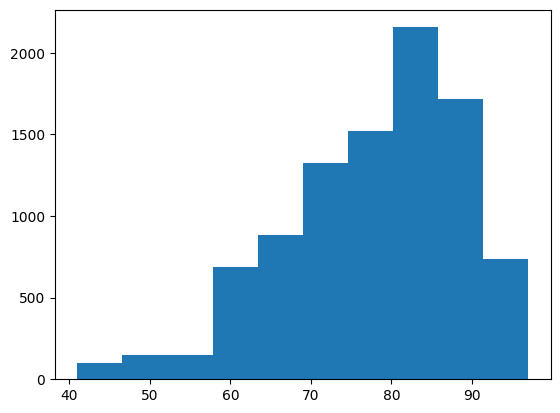

77.71354166666667 10.929043109528417
334.9270833333333 117.8748227987062


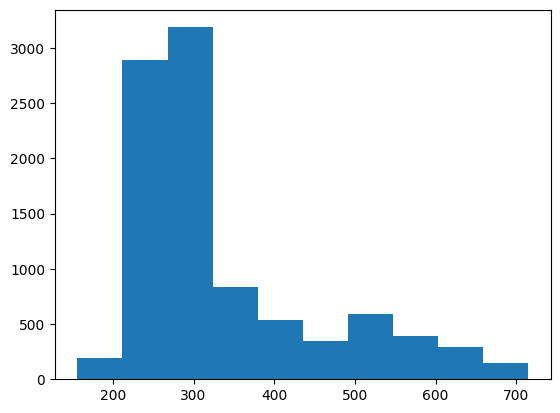

In [15]:
import matplotlib.pyplot as plt
plt.hist(clin_data[:,:,0].flatten())
plt.show()
plt.hist(clin_data[:,:,1].flatten())
zero = clin_data[:,:,0].flatten()
one = clin_data[:,:,1].flatten()
print( np.mean(zero), np.std(zero))
print(np.mean(one), np.std(one))

In [31]:
print(bio_markers.shape)
bio_nan = ~np.isnan(bio_markers).any(axis=2)

bio = bio_markers[bio_nan]
print(bio.shape)
print(np.sum(bio,0)) # 2(32), 9(10), 13(10), 14(10), 15(76)

print(np.argwhere(bio[:,2]==1)//98) # 55,61,66,73
print(np.argwhere(bio[:,9]==1)//98) # 21, 30, 78
print(np.argwhere(bio[:,13]==1)//98) #0,9,10,52,85,86
print(np.argwhere(bio[:,14]==1)//98) # 17 

# rare_idx = np.argwhere(bio[:,[2,9,13,14]]==1)
# rare_eye = rare_idx // 98
# print(rare_eye)

(96, 98, 16)
(9396, 16)
[ 166.  604.   32.  373. 6338. 2984. 5216.  807. 2836.   10. 3003. 4087.
  233.   10.   10.   76.]
[[55]
 [55]
 [55]
 [55]
 [55]
 [55]
 [55]
 [55]
 [55]
 [61]
 [66]
 [66]
 [66]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]
 [73]]
[[21]
 [21]
 [21]
 [30]
 [30]
 [30]
 [78]
 [78]
 [78]
 [78]]
[[ 0]
 [ 0]
 [ 0]
 [ 0]
 [ 9]
 [10]
 [10]
 [52]
 [85]
 [86]]
[[17]
 [17]
 [17]
 [17]
 [17]
 [17]
 [17]
 [17]
 [17]
 [17]]


In [4]:
'''
Data setup - No Stratification (OCT + clinical label)

'''

# Eye-wise split
# Split dataset into train/val/test

# Clinical data (96,98,2)
train_val_files, test_files, train_val_labels, test_labels, train_val_clin, test_clin = train_test_split(
    file_paths, bio_markers, clin_data, test_size=0.2, random_state=42
)

train_files, val_files, train_labels, val_labels, train_clin, val_clin = train_test_split(
    train_val_files, train_val_labels, train_val_clin, test_size=0.25, random_state=42
)
print(train_files.shape, val_files.shape, test_files.shape)
# Eye-wise -> scan-wise
train_files = train_files.reshape([-1,1])
val_files = val_files.reshape([-1,1])
test_files = test_files.reshape([-1,1])

train_labels = train_labels.reshape([-1,16])
val_labels = val_labels.reshape([-1,16])
test_labels = test_labels.reshape([-1,16])

train_clin = train_clin.reshape([-1,2])
val_clin = val_clin.reshape([-1,2])
test_clin = test_clin.reshape([-1,2])

######## Get rid of data points with Nan values #########
train_nan = ~np.isnan(train_labels).any(axis=1)
val_nan = ~np.isnan(val_labels).any(axis=1)
test_nan = ~np.isnan(test_labels).any(axis=1)

train_labels = train_labels[train_nan]
val_labels = val_labels[val_nan]
test_labels = test_labels[test_nan]

train_files = train_files[train_nan]
val_files = val_files[val_nan]
test_files = test_files[test_nan]

train_clin = train_clin[train_nan]
val_clin = val_clin[val_nan]
test_clin = test_clin[test_nan]
#########################################################

train_dataset = OCTDataset(train_files, train_labels, train_clin, transform=transform_deit)
val_dataset = OCTDataset(val_files, val_labels, val_clin, transform=transform_deit)
test_dataset = OCTDataset(test_files, test_labels, test_clin, transform=transform_deit)

# Make DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

(57, 98) (19, 98) (20, 98)


In [21]:
print(np.sum(train_labels, 0),np.sum(val_labels, 0),np.sum(test_labels, 0))

[1.280e+02 3.500e+02 4.000e+00 2.460e+02 3.815e+03 1.627e+03 3.251e+03
 5.300e+02 1.853e+03 7.000e+00 1.849e+03 2.528e+03 1.430e+02 3.000e+00
 1.000e+01 3.500e+01] [1.600e+01 1.050e+02 9.000e+00 6.900e+01 1.102e+03 5.850e+02 1.086e+03
 9.700e+01 6.180e+02 0.000e+00 4.600e+02 6.430e+02 3.700e+01 1.000e+00
 0.000e+00 1.600e+01] [  22.  149.   19.   58. 1421.  772.  879.  180.  365.    3.  694.  916.
   53.    6.    0.   25.]


In [5]:
# Weighted BCE for multi-label imbalanced (pos vs. neg) data

train_pos_weights = torch.tensor(train_labels.shape[0] / (2* np.sum(train_labels,axis=0)))
# val_pos_weights = val_labels.shape[0] / (2* np.sum(val_labels,axis=0))
# test_pos_weights = test_labels.shape[0] / (2* np.sum(test_labels,axis=0))

class WeightedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self, pos_weights):
        """
        pos_weights: Tensor of shape (num_biomarkers,) containing weights for positive labels.
        """
        super(WeightedBinaryCrossEntropyLoss, self).__init__()
        self.pos_weights = pos_weights

    def forward(self, logits, targets):
        """
        logits: Predicted logits from the model, shape (batch_size, num_biomarkers).
        targets: Ground truth binary labels, shape (batch_size, num_biomarkers).
        """
        loss = nn.BCEWithLogitsLoss(reduction='none')(logits, targets)  # Compute BCE loss
        weighted_loss = loss * self.pos_weights  # Apply positive weights
        return weighted_loss.mean()
    


class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        Focal Loss for multi-label classification.

        Parameters:
        - gamma (float): Focusing parameter that reduces the loss for well-classified samples (default: 2.0).
        - alpha (float or Tensor): Balancing factor to address class imbalance (default: None).
          If a tensor is provided, it should be of shape (num_classes,).
        - reduction (str): Specifies the reduction to apply to the output: 'none', 'mean', 'sum' (default: 'mean').
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, targets):
        """
        Compute Focal Loss.

        Parameters:
        - logits (Tensor): Predicted logits of shape (batch_size, num_classes).
        - targets (Tensor): Ground truth labels of shape (batch_size, num_classes).

        Returns:
        - loss (Tensor): Calculated focal loss.
        """
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(logits)
        
        # Binary cross-entropy loss
        bce_loss = F.binary_cross_entropy(probs, targets, reduction='none')
        
        # Compute the modulating factor (1 - p_t)^gamma
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal_factor = (1 - pt) ** self.gamma

        # Apply class balancing factor alpha if provided
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_factor = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            elif isinstance(self.alpha, torch.Tensor):
                alpha_factor = self.alpha.unsqueeze(0) * targets + (1 - self.alpha).unsqueeze(0) * (1 - targets)
            else:
                raise ValueError("Alpha must be a float, int, or torch.Tensor.")
            focal_loss = alpha_factor * focal_factor * bce_loss
        else:
            focal_loss = focal_factor * bce_loss

        # Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# Initialize Focal Loss (Example)
# 1. gamma (Focusing Parameter):
# Controls the strength of the focusing effect.
# Higher values put more focus on hard-to-classify samples.

# 2. alpha (Class Balancing Factor):
# Helps address class imbalance.
# If alpha is a scalar, it applies the same balancing for all classes.
# If alpha is a tensor, it applies per-class balancing.

# 3. reduction:
# 'mean': Average loss across the batch.
# 'sum': Sum of the loss across the batch.
# 'none': No reduction is applied; returns loss for each sample.

focal_loss = FocalLoss(gamma=2.0, alpha=0.25)


In [6]:
import timm 
import tqdm

# Load model (model_name, )
model_name = 'deit_base_patch16_384'
input_dim = 384
print(f'model name {model_name}, input size {input_dim}')
model = timm.create_model(model_name, pretrained=True) 
print(model.head)
###### Parameters ######
lr = 1e-3
num_classes = 16
epochs = 10
########################

# print(model.head)
model = model.to('cuda')
model.eval()
for param in model.parameters():
    param.requires_grad = False

######### Get mean and std of DeiT features #########

get_extract = np.zeros([len(train_dataset),model.head.in_features])
with torch.no_grad():
    batch = 0
    for img, label, clin in train_loader:
        features = model.forward_features(img.to('cuda'))
        get_extract[batch*batch_size:min((batch+1)*batch_size, len(train_dataset))] = features[:,0,:].cpu()
        batch+=1
deit_mean = np.mean(get_extract)
deit_std = np.std(get_extract)
print(f'deit mean {deit_mean}, std {deit_std}')
        



model name deit_base_patch16_384, input size 384
Linear(in_features=768, out_features=1000, bias=True)
deit mean -0.0003475529297967371, std 0.8226618576021918


-0.0066544563 0.8229257


5582

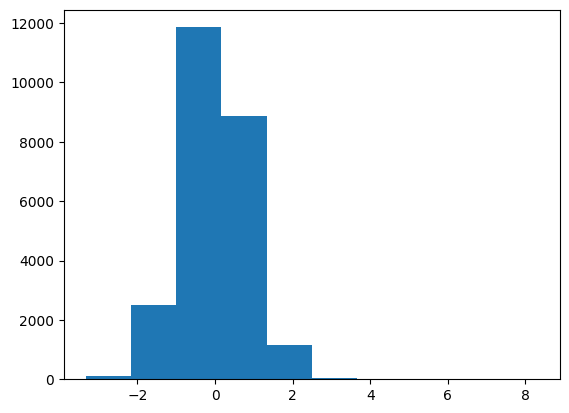

In [22]:
# features = np.array(features.cpu())
plt.hist(features[:,0,:].flatten()) # CLS token
print(np.mean(features[:,0,:]), np.std(features[:,0,:]))
model.head.in_features
len(train_dataset)

In [9]:
import timm 
import tqdm

# Load model (model_name, )
# model_name = 'deit_base_patch16_224'
# input_dim = 224
# print(f'model name {model_name}, input size {input_dim}')
# model = timm.create_model(model_name, pretrained=True) 
# print(model.head)
###### Parameters ######
lr = 1e-3
num_classes = 16
feature_dim = model.head.in_features
clin_dim = 2
epochs = 10
########################


##### Setup deit Model ##########
model_name = 'deit_base_patch16_384'
input_dim = 384
print(f'model name {model_name}, input size {input_dim}')
deit_model = timm.create_model(model_name, pretrained=True) 

print(deit_model.head)

deit_model.head = nn.Sequential(
    nn.Linear(model.head.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes),  # 16 biomarkers
    nn.Sigmoid()  # Multi-label classification (probabilities for each class)
)
print(deit_model.head)

deit_model = deit_model.to('cuda')
# model.eval()
for param in deit_model.parameters():
    param.requires_grad = False
for param in deit_model.head.parameters():
    param.requires_grad = True
###################################

####### Setup MLP Model ########
class Clin_MLP(nn.Module):
    def __init__(self, num_classes):
        super(Clin_MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(2, 64), 
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, num_classes),  
            nn.Sigmoid() 
        )
    
    def forward(self, x):
        return self.mlp(x)

##########Ensemble model ##########
class EnsembleModel(nn.Module):
    def __init__(self, deit_model, clin_mlp):
        super(EnsembleModel, self).__init__()
        self.deit_model = deit_model
        self.clin_mlp = clin_mlp
    
    def forward(self, image, clin):
        deit_preds = self.deit_model(image)
        clinical_preds = self.clin_mlp(clin)
        
        # simple average of predictions
        final_preds = (deit_preds + clinical_preds)/2
        return final_preds

##################################

clin_mlp = Clin_MLP(num_classes).to('cuda')
for param in clin_mlp.parameters():
    param.requires_grad = True 
    
ensemble_model = EnsembleModel(deit_model, clin_mlp).to('cuda')

########################
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, ensemble_model.parameters()), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

######### Loss ###########
# criterion = torch.nn.BCELoss()  # Binary Cross-Entropy Loss for multi-label classification
criterion = WeightedBinaryCrossEntropyLoss(train_pos_weights.to('cuda'))
# criterion = FocalLoss(gamma=2.0, alpha=0.25)
##########################

# Training and validation
def train_one_epoch(ensemble_model, train_loader, optimizer, criterion):
    ensemble_model.train()
    running_loss = 0.0  
    for images, labels, clin in tqdm.tqdm(train_loader):
        images, labels, clin = images.to('cuda'), labels.to('cuda'), clin.to('cuda')
        
        # Normalize clinical data to fit deit mean, std
        # clin [batch_size, 2]
        clin = (clin - torch.mean(clin)) / torch.std(clin) * deit_std + deit_mean        
        optimizer.zero_grad()
        outputs = ensemble_model(images, clin)
        loss = criterion(outputs, labels)
#         print('loss : ',loss.item())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(train_loader)

def validate_one_epoch(ensemble_model, val_loader, criterion):
    ensemble_model.eval()
    running_loss = 0.0
    all_outputs = np.zeros([len(val_dataset),num_classes])
    all_labels = np.zeros([len(val_dataset),num_classes])
    i = 0
    with torch.no_grad():
        for images, labels, clin in tqdm.tqdm(val_loader):
            images, labels, clin = images.to('cuda'), labels.to('cuda'), clin.to('cuda')
        
            # Normalize clinical data to fit deit mean, std
            # clin [batch_size, 2]
#             clin = (clin - deit_mean)/deit_std
            clin = (clin - torch.mean(clin)) / torch.std(clin) * deit_std + deit_mean
            
            outputs = ensemble_model(images, clin)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
#             print(i*batch_size, min((i+1)*batch_size,len(val_dataset)))
#             print(outputs.shape)
            all_outputs[i*batch_size: min((i+1)*batch_size,len(val_dataset)),:] = outputs.cpu()
            all_labels[i*batch_size: min((i+1)*batch_size,len(val_dataset)),:] = labels.cpu()
            i+=1

    return running_loss / len(val_loader), all_outputs, all_labels

# Training loop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    
    train_loss = train_one_epoch(ensemble_model, train_loader, optimizer, criterion)
    val_loss, val_outputs, val_labels = validate_one_epoch(ensemble_model, val_loader, criterion)
    
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    scheduler.step()



model name deit_base_patch16_384, input size 384
Linear(in_features=768, out_features=1000, bias=True)
Sequential(
  (0): Linear(in_features=768, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=512, out_features=16, bias=True)
  (4): Sigmoid()
)
Epoch 1/10


100%|██████████| 58/58 [00:58<00:00,  1.00s/it]


Train Loss: 111.9469, Val Loss: 106.5340
Epoch 2/10


100%|██████████| 58/58 [01:32<00:00,  1.60s/it]


Train Loss: 106.5830, Val Loss: 106.5232
Epoch 3/10


100%|██████████| 58/58 [01:38<00:00,  1.70s/it]


Train Loss: 106.5373, Val Loss: 106.5210
Epoch 4/10


100%|██████████| 58/58 [01:40<00:00,  1.73s/it]


Train Loss: 106.5253, Val Loss: 106.5177
Epoch 5/10


100%|██████████| 58/58 [01:37<00:00,  1.69s/it]


Train Loss: 106.5185, Val Loss: 106.5171
Epoch 6/10


100%|██████████| 58/58 [01:34<00:00,  1.63s/it]


Train Loss: 106.5154, Val Loss: 106.5171
Epoch 7/10


100%|██████████| 58/58 [01:35<00:00,  1.65s/it]


Train Loss: 106.5146, Val Loss: 106.5171
Epoch 8/10


100%|██████████| 58/58 [01:33<00:00,  1.61s/it]


Train Loss: 106.5157, Val Loss: 106.5170
Epoch 9/10


100%|██████████| 58/58 [01:34<00:00,  1.63s/it]


Train Loss: 106.5149, Val Loss: 106.5170
Epoch 10/10


100%|██████████| 58/58 [01:11<00:00,  1.23s/it]

Train Loss: 106.5131, Val Loss: 106.5171


In [45]:
len(val_dataset)

1854

In [12]:
import sklearn
'''
Optimize biomarker-wise threshold for validation on eval metrics

'''

def optimal_thresholds(model_outputs, labels, metric='f1'):
    """
    Calculate optimal thresholds for each biomarker.
    
    Parameters:
        model_outputs (ndarray): Model predictions, shape (N, 16) where N is the number of samples.
        labels (ndarray): True binary labels, shape (N, 16).
        metric (str): Metric to optimize. Options: 'f1', 'auc'.

    Returns:
        thresholds (list): Optimal threshold for each biomarker.
        scores (list): Corresponding best scores for each biomarker.
    """
    num_biomarkers = model_outputs.shape[1]
    thresholds = []
    scores = []
    
    for i in range(num_biomarkers):
        best_threshold = 0.0
        best_score = 0.0
        
        # Thresholds to search
        thresholds_range = np.linspace(0, 1, 100)
        
        for threshold in thresholds_range:
            preds = (model_outputs[:, i] >= threshold).astype(int)
            
            if metric == 'f1':
                score = sklearn.metrics.f1_score(labels[:, i], preds)
            elif metric == 'auc':
                try:
                    score = sklearn.metrics.roc_auc_score(labels[:,i],model_outputs[:,i])
                except ValueError:
                    score = np.nan
#                 # AUC does not depend on a threshold
#                 score = sklearn.metrics.roc_auc_score(labels[:, i], model_outputs[:, i])
#                 best_threshold = None  # No threshold needed for AUC
                
            else:
                raise ValueError("Unsupported metric. Use 'f1' or 'auc'.")
            
            if score > best_score:
                best_score = score
                best_threshold = threshold
        
        thresholds.append(best_threshold)
        scores.append(best_score)
    
    return thresholds, scores

f1_th, f1_scores = optimal_thresholds(val_outputs, val_labels, metric='f1')
# auc_th, auc_scores = optimal_thresholds(val_outputs, val_labels, metric='auc')
print(f'F1 threshold {f1_th}, F1 validation scores {f1_scores}')
# print(f'AUC threshold {auc_th}, AUC validation scores {auc_scores}')
      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metr

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metr

F1 threshold [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010101010101010102, 0.0, 0.0, 0.0, 0.16161616161616163, 0.16161616161616163, 0.0, 0.0, 0.0, 0.0], F1 validation scores [0.017112299465240642, 0.10719754977029096, 0.00966183574879227, 0.0717628705148206, 0.7456021650879567, 0.4797047970479705, 0.770153730783652, 0.09943618657098924, 0.5, 0.0, 0.84375, 0.7464671654197839, 0.03913273400317292, 0.001078167115902965, 0.0, 0.017112299465240642]


In [41]:
a = np.array(val_outputs)
a = np.zeros([len(val_loader),16])
for i in range(len(val_outputs)):
    a[i*batch_size:(i+1)*batch_size] = 
a = [np.array(out) for out in val_outputs]
# a[0].shape

/scratch/995974/ipykernel_1802866/2211902833.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  a = np.array(val_outputs)
/scratch/995974/ipykernel_1802866/2211902833.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.array(val_outputs)


torch.Size([32, 16])

In [17]:
# Get F1 scores and AUC 
import sklearn
import torch
import json
import numpy as np
import timm
import tqdm
from torch import nn
test_shape = test_labels.shape
 
def test_with_eval_metric(ensemble_model, test_loader, threshold, batch_size, output_path):
    """
    Evaluate the model using test data and save F1, AUC scores, and thresholds as JSON.
 
    Parameters:
        model (torch.nn.Module): Trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        threshold (list): List of thresholds for classification.
        batch_size (int): Batch size.
        output_path (str): Path to save the JSON metrics file.
    """
    ensemble_model.eval()
    test_shape = (len(test_loader.dataset), len(threshold))
    target = np.zeros(test_shape)
    pred = np.zeros(test_shape)
 
    threshold_tensor = torch.tensor(threshold).to("cuda")
 
    with torch.no_grad():
        for batch, (images, labels, clin) in enumerate(test_loader):
            images, labels, clin = images.to("cuda"), labels.to("cuda"), clin.to('cuda')
            
            clin = (clin - torch.mean(clin)) / torch.std(clin) * deit_std + deit_mean

            # Get image features from vision model
#             with torch.no_grad():
#                 img_features = model.forward_features(images)
#                 img_features = img_features[:,0,:] # Get CLS tokens

#             combined_features = torch.cat((img_features, clin), dim=1)
            outputs = ensemble_model(images,clin)
            pred[
                batch * batch_size : min((batch + 1) * batch_size, len(test_loader.dataset))
            ] = (outputs > threshold_tensor).float().cpu()
            target[
                batch * batch_size : min((batch + 1) * batch_size, len(test_loader.dataset))
            ] = labels.cpu()
 
    metrics = {}
    for i in range(len(threshold)):
        f1 = sklearn.metrics.f1_score(target[:, i], pred[:, i], zero_division=0)
        try:
            auc = sklearn.metrics.roc_auc_score(target[:, i], pred[:, i])
        except ValueError:
            auc = np.nan
        metrics[f"Biomarker_{i}"] = {
            "F1": f1,
            "AUC": auc,
            "Threshold": threshold[i]
        }
        print(f1)
 
    # Save to JSON
    with open(output_path, "w") as json_file:
        json.dump(metrics, json_file, indent=4)
    print(f"Metrics saved to {output_path}")
 
 
# Eval test with optimized F1 Threshold
opt_path = "deit384_ensemble_f1_threshold_metrics.json"
default_path = "deit384_ensemble_0.5_threshold_metrics.json"
print("optimized th")
test_with_eval_metric(ensemble_model, test_loader, threshold=f1_th, batch_size=batch_size, output_path=opt_path)
print("0.5 th")
test_with_eval_metric(ensemble_model, test_loader, threshold=[0.5]*16, batch_size=batch_size, output_path=default_path)

optimized th
0.022199798183652877
0.14129919393077287
0.019201616978271854
0.057482656095143705
0.8405797101449275
0.5651537335285505
0.6985230234578628
0.16822429906542055
0.3139784946236559
0.003056546102903719
0.8334578043315908
0.8132635253054101
0.05265772478887233
0.006103763987792472
0.0
0.02518891687657431
Metrics saved to deit384_ensemble_f1_threshold_metrics.json
0.5 th
0.0
0.0
0.0
0.0
0.8559726962457338
0.0
0.0390032502708559
0.0
0.0
0.0
0.0
0.39304347826086955
0.0
0.0
0.0
0.0
Metrics saved to deit384_ensemble_0.5_threshold_metrics.json
